In [80]:
from ucimlrepo import fetch_ucirepo 

In [81]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import label_binarize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

from tabpfn import TabPFNClassifier
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')
import logging
logging.disable(logging.CRITICAL)


dataset = 'iris'

ident = {
    'iris' : 53
}
target = fetch_ucirepo(id=ident[dataset]).data.targets.columns [0]
df = fetch_ucirepo(id=ident[dataset]).data.original

## Просмотр первых строк набора данных

In [82]:
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Получение сводной статистики

In [83]:
df.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## Вывод информации о типах данных и пропущенных значениях

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal length  150 non-null    float64
 1   sepal width   150 non-null    float64
 2   petal length  150 non-null    float64
 3   petal width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## Подсчёт пропущенных значений в каждом столбце

In [85]:
df.isnull().sum()

sepal length    0
sepal width     0
petal length    0
petal width     0
class           0
dtype: int64

## Визуализация распределения числовых признаков

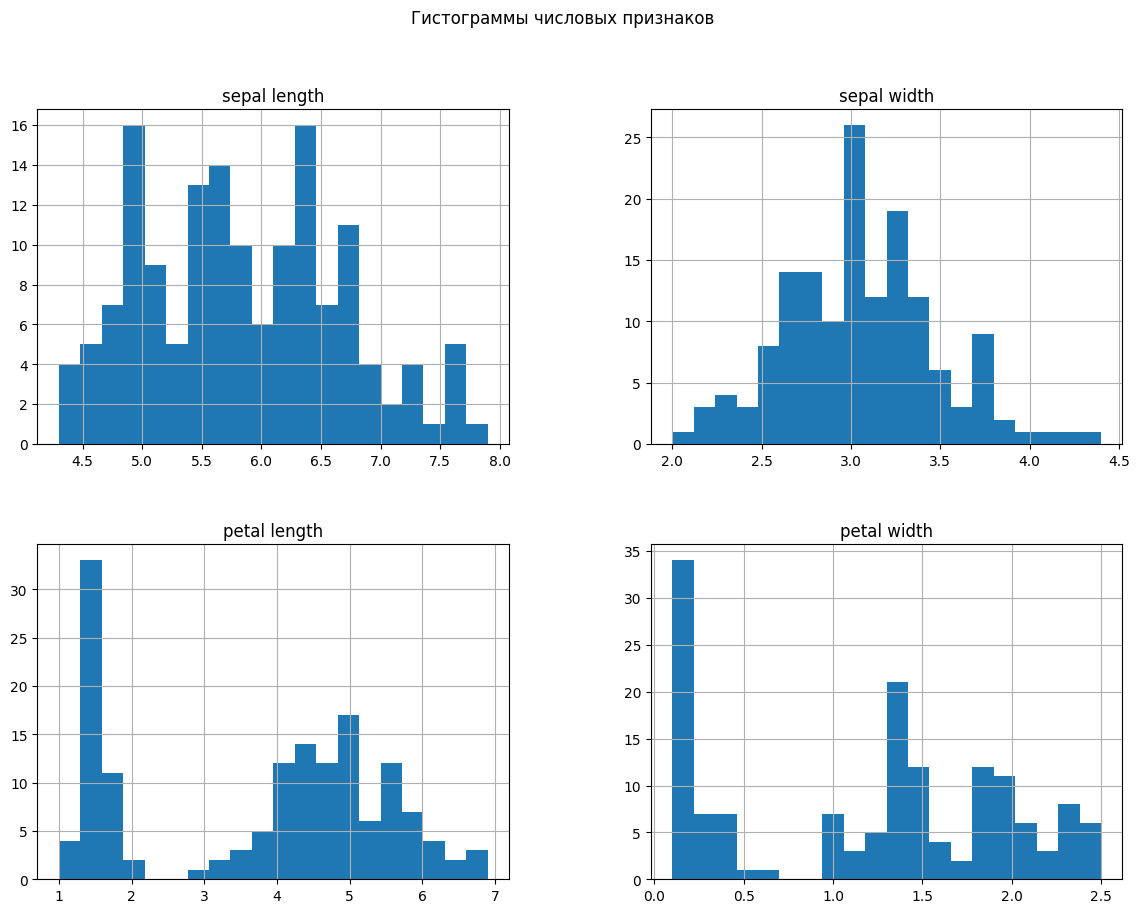

In [86]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
df[numeric_features].hist(bins=20, figsize=(14, 10))
plt.suptitle("Гистограммы числовых признаков")
plt.show()

## Построение корреляционной матрицы для числовых признаков

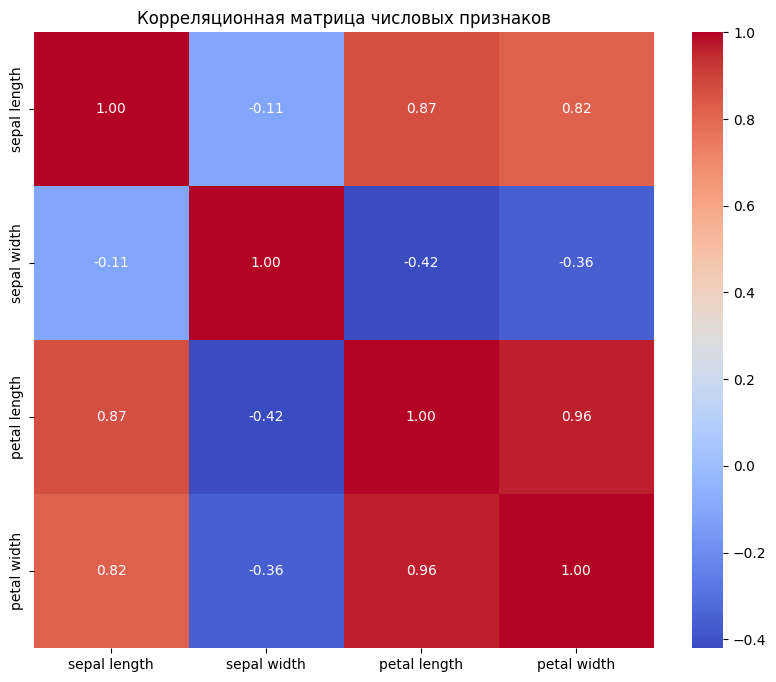

In [87]:
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица числовых признаков")
plt.show()

## Заполнение пропущенных значений для категориальных признаков

In [88]:
# на наиболее частое значение
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

## Заполнение пропущенных значений для числовых признаков (если имеются)

In [89]:
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())

## Удаление дубликатов

In [90]:
df.drop_duplicates(inplace=True)

## Преобразование категориальных признаков с помощью one-hot encoding

In [91]:
categorical_features =  [i for i in df.select_dtypes(include=['object']).columns.tolist() if i!=fetch_ucirepo(id=ident[dataset]).data.targets.columns [0]]
print(categorical_features)
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

[]


## Вид конечного набора данных:

In [92]:
df

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


## Разделение данных на признаки (X) и целевую переменную (y)

In [93]:
X = df.drop(fetch_ucirepo(id=ident[dataset]).data.targets.columns [0], axis=1)
y = df[fetch_ucirepo(id=ident[dataset]).data.targets.columns [0]]

In [94]:
from sklearn.preprocessing import LabelEncoder
y = pd.Series(LabelEncoder().fit_transform(y))

## Разделение выборки на обучающую и тестовую (80% / 20%)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (117, 4)
Размер тестовой выборки: (30, 4)


## Обучение модели RandomForestClassifier

In [96]:
rf = RandomForestClassifier(random_state=42)

start_time = time.time()
rf.fit(X_train, y_train)
rf_training_time = time.time() - start_time

print("Время обучения RandomForestClassifier: {:.4f} секунд".format(rf_training_time))

Время обучения RandomForestClassifier: 0.1286 секунд


## Предсказание и оценка модели RandomForestClassifier

In [97]:
rf_pred = rf.predict(X_test)

print("RandomForest Accuracy:", accuracy_score(y_test, rf_pred))
print("\nОтчет по классификации для RandomForestClassifier:")
print(classification_report(y_test, rf_pred))

RandomForest Accuracy: 0.9333333333333333

Отчет по классификации для RandomForestClassifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       0.90      0.90      0.90        10
           2       0.89      0.89      0.89         9

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



## Подбор гиперпараметров для RandomForestClassifier с помощью GridSearchCV

In [98]:
# Определение сетки гиперпараметров для RandomForest
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid,
                       cv=3,
                       n_jobs=-1,
                       scoring='accuracy')

start_time = time.time()
grid_rf.fit(X_train, y_train)
grid_training_time = time.time() - start_time

print("Лучшие параметры RandomForest:", grid_rf.best_params_)
print("Время GridSearchCV: {:.4f} секунд".format(grid_training_time))
print("Лучшая точность по кросс-валидации:", grid_rf.best_score_)

Лучшие параметры RandomForest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}
Время GridSearchCV: 0.5931 секунд
Лучшая точность по кросс-валидации: 0.9658119658119658


## Обучение модели XGBoostClassifier и её оценка

In [99]:
# Обучение модели XGBoostClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

start_time = time.time()
xgb.fit(X_train, y_train)
xgb_training_time = time.time() - start_time

print("Время обучения XGBoostClassifier: {:.4f} секунд".format(xgb_training_time))

# Оценка XGBoostClassifier
xgb_pred = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("\nОтчет по классификации для XGBoostClassifier:")
print(classification_report(y_test, xgb_pred))

Время обучения XGBoostClassifier: 0.0767 секунд
XGBoost Accuracy: 0.9

Отчет по классификации для XGBoostClassifier:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.89      0.80      0.84        10
           2       0.89      0.89      0.89         9

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



## Обучение модели TabPFNClassifier

In [100]:
# Преобразование данных в тип np.float32 для TabPFN
X_train_tabpfn = X_train.values.astype(np.float32)
y_train_tabpfn = y_train.values.astype(np.float32)
X_test_tabpfn = X_test.values.astype(np.float32)
y_test_tabpfn = y_test.values.astype(np.float32)

# Инициализация модели TabPFNClassifier
clf_tabpfn = TabPFNClassifier(n_estimators=32, random_state=42, ignore_pretraining_limits=True)

# Замер времени обучения модели TabPFNClassifier
start_time = time.time()
clf_tabpfn.fit(X_train_tabpfn, y_train_tabpfn)
tabpfn_training_time = time.time() - start_time

print("Время обучения TabPFNClassifier: {:.4f} секунд".format(tabpfn_training_time))

# Предсказание и оценка модели TabPFNClassifier
tabpfn_pred = clf_tabpfn.predict(X_test_tabpfn)
print("TabPFN Accuracy:", accuracy_score(y_test_tabpfn, tabpfn_pred))
print("\nОтчет по классификации для TabPFNClassifier:")
print(classification_report(y_test_tabpfn, tabpfn_pred))

Время обучения TabPFNClassifier: 0.2123 секунд
TabPFN Accuracy: 0.9666666666666667

Отчет по классификации для TabPFNClassifier:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        11
         1.0       1.00      0.90      0.95        10
         2.0       0.90      1.00      0.95         9

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



## Сравнение времени обучения и точности моделей

In [101]:
results = {
    'Модель': ['RandomForest', 'GridSearch RF (CV)', 'XGBoost', 'TabPFN'],
    'Время обучения (сек.)': [rf_training_time, grid_training_time, xgb_training_time, tabpfn_training_time],
    'Точность на тестовой выборке': [
        accuracy_score(y_test, rf_pred),
        grid_rf.best_score_,  # Это оценка по кросс-валидации
        accuracy_score(y_test, xgb_pred),
        accuracy_score(y_test.to_numpy(), tabpfn_pred)
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

               Модель  Время обучения (сек.)  Точность на тестовой выборке
0        RandomForest               0.128606                      0.933333
1  GridSearch RF (CV)               0.593097                      0.965812
2             XGBoost               0.076743                      0.900000
3              TabPFN               0.212303                      0.966667


## Сделаем обучение нескольких моделей функцией 

In [110]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title(f"Learning Curves ({estimator.__class__.__name__})")
    plt.show()



def compare_models_classifier(dataset, models, params=None, ident = {}, verbose = 0):
       
    
    target = fetch_ucirepo(id=ident[dataset]).data.targets.columns [0]
    df = fetch_ucirepo(id=ident[dataset]).data.original

    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].fillna(df[col].mode()[0])
        
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(df[col].median())

    df.drop_duplicates(inplace=True)

    categorical_features =  [i for i in df.select_dtypes(include=['object']).columns.tolist() if i!=fetch_ucirepo(id=ident[dataset]).data.targets.columns [0]]
    
    
    for col in categorical_features:
        plt.figure(figsize=(8, 4))
        df[col].value_counts().plot(kind='bar')
        plt.title(f"Распределение признака: {col}")
        plt.show()
        
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

   
    
    X = df.drop(fetch_ucirepo(id=ident[dataset]).data.targets.columns [0], axis=1)
    y = df[fetch_ucirepo(id=ident[dataset]).data.targets.columns [0]]
    
    # Добавляем визуализацию распределения классов
    plt.figure(figsize=(8, 5))
    sns.countplot(y=y, order=y.value_counts().index)
    plt.title("Распределение классов в целевой переменной")
    plt.show()
    
    # покажем гистограммы
    try:
        
        numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
        df[numeric_features].hist(bins=20, figsize=(14, 10))
        plt.suptitle("Гистограммы числовых признаков")
        plt.show()
    except:
        pass
    
    
    # покажем коррелограмму
    plt.figure(figsize=(10, 8))
    corr_matrix = df[numeric_features].corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Корреляционная матрица числовых признаков")
    plt.show()
    


    # Новая визуализация boxplot для числовых признаков
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df[numeric_features], orient="h")
    plt.title("Boxplot числовых признаков")
    plt.show()




    
    y = pd.Series(LabelEncoder().fit_transform(y))

    len_y_u = y.unique().__len__()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    times = []
    accuracys = []
    roc_auc_scores = []
    for i in range(len(models)):
        if params[i]:
            rf = models[i](**params[i])
        else:
            rf = models[i]()

        start_time = time.time()
        rf.fit(X_train, y_train)
        rf_training_time = time.time() - start_time

        if verbose:
            print(f"\nВремя обучения {models[i].__name__}: {round(rf_training_time,4)} секунд")
        times.append(rf_training_time)
        rf_pred = rf.predict(X_test)
        
        if verbose:
            print(f"{models[i].__name__} Accuracy:", accuracy_score(y_test, rf_pred))
        accuracys.append(accuracy_score(y_test, rf_pred))
        
        if len_y_u>2:
            if verbose:
                print(f"{models[i].__name__} ROC-AUC:", roc_auc_score(y_test.values,rf.predict_proba(X_test),multi_class = 'ovr'))
            roc_auc_scores.append(roc_auc_score(y_test.values,rf.predict_proba(X_test),multi_class = 'ovr'))
        else:
            if verbose:
                print(f"{models[i].__name__} ROC-AUC:", roc_auc_score(y_test.values,rf.predict_proba(X_test)[:,1]))
            roc_auc_scores.append(roc_auc_score(y_test.values,rf.predict_proba(X_test)[:,1]))
            
        plot_learning_curve(rf, X_train, y_train)
        
        
            
        # Добавляем confusion matrix
        plt.figure(figsize=(6, 6))
        cm = confusion_matrix(y_test, rf_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=rf.classes_, 
                    yticklabels=rf.classes_)
        plt.title(f"Confusion Matrix: {models[i].__name__}")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        # Добавляем ROC-кривую
        if len_y_u == 2:
            fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                     label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC-кривая для {models[i].__name__}')
            plt.legend(loc="lower right")
            plt.show()
        
        # Визуализация важности признаков для совместимых моделей
        if hasattr(rf, 'feature_importances_'):
            importances = rf.feature_importances_
            indices = np.argsort(importances)[::-1]
            
            plt.figure(figsize=(10, 6))
            plt.title(f"Важность признаков: {models[i].__name__}")
            plt.bar(range(X.shape[1]), importances[indices], align="center")
            plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
            plt.tight_layout()
            plt.show()
        

    # Преобразование данных в тип np.float32 для TabPFN
    X_train_tabpfn = X_train.values.astype(np.float32)
    y_train_tabpfn = y_train.values.astype(np.float32)
    X_test_tabpfn = X_test.values.astype(np.float32)
    y_test_tabpfn = y_test.values.astype(np.float32)

    # Инициализация модели TabPFNClassifier
    clf_tabpfn = TabPFNClassifier(n_estimators=32, random_state=42, ignore_pretraining_limits=True)

    # Замер времени обучения модели TabPFNClassifier
    start_time = time.time()
    clf_tabpfn.fit(X_train_tabpfn, y_train_tabpfn)
    tabpfn_training_time = time.time() - start_time

    if verbose:
        print("\n\nВремя обучения TabPFNClassifier: {:.4f} секунд".format(tabpfn_training_time))

    # Предсказание и оценка модели TabPFNClassifier
    tabpfn_pred = clf_tabpfn.predict(X_test_tabpfn)
    if verbose:
        print("TabPFN Accuracy:", accuracy_score(y_test_tabpfn, tabpfn_pred))
        print("\nОтчет по классификации для TabPFNClassifier:")
        print(classification_report(y_test_tabpfn, tabpfn_pred))
    
    if len_y_u>2:
        roc_tabfpn = roc_auc_score(y_test.to_numpy(), clf_tabpfn.predict_proba(X_test_tabpfn),multi_class = 'ovr')
    else:
        roc_tabfpn = roc_auc_score(y_test.to_numpy(), clf_tabpfn.predict_proba(X_test_tabpfn)[:,1])
    results = {
        'Модель': [*list(map(lambda x: x.__name__, models)), 'TabPFN'],
        'Время обучения (сек.)': [*times, tabpfn_training_time],
        'Точность на тестовой выборке': [*accuracys, accuracy_score(y_test.to_numpy(), tabpfn_pred)],
        'Площадь под ROC': [*roc_auc_scores, roc_tabfpn]
    }
    results_df = pd.DataFrame(results)
    if verbose:
        print(f'\n\n\n{dataset}:')
        # Добавляем сводную визуализацию метрик
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))
    
    # Точность
    sns.barplot(x='Точность на тестовой выборке', y='Модель', 
                data=results_df, ax=axes[0])
    axes[0].set_title("Сравнение точности моделей")
    
    # Время обучения
    sns.barplot(x='Время обучения (сек.)', y='Модель', 
                data=results_df, ax=axes[1])
    axes[1].set_title("Сравнение времени обучения")
    
    # ROC-AUC
    sns.barplot(x='Площадь под ROC', y='Модель', 
                data=results_df, ax=axes[2])
    axes[2].set_title("Сравнение ROC-AUC")
    
    plt.tight_layout()
    plt.show()
    
    return results_df

## Обучим модели на разных датасетах

In [105]:
base_estimators = [
    ('lgb', lgb.LGBMClassifier(n_estimators=500, learning_rate=0.01, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=500, learning_rate=0.01, random_state=42,
                              use_label_encoder=False, eval_metric='auc')),
    ('cb', CatBoostClassifier(iterations=500, learning_rate=0.01, random_seed=42, verbose=0)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
]


models = [
    RandomForestClassifier,
    RandomForestClassifier,
    XGBClassifier,
    lgb.LGBMClassifier,
    CatBoostClassifier,
    StackingClassifier,
    ]

params = [
    {},
    {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50},
    {'use_label_encoder':False, 'eval_metric':'logloss', 'random_state':42},
    {'n_estimators':500, 'learning_rate':0.01, 'random_state':42},
    {'iterations':500, 'learning_rate':0.01, 'random_seed':42, 'verbose':0},
    {'estimators':base_estimators,'final_estimator': LogisticRegression(max_iter=1000),'cv':5,'passthrough':True,'n_jobs':-1}
]

ident = {
    'iris' : 53,
    'Ionosphere' : 52,
    'ttt': 101,
    'cancer': 451,
    'Thoracic':277,
    'Diabetic':329,
    #'Students':697,
    #'Page': 78
}

results = dict()

### iris

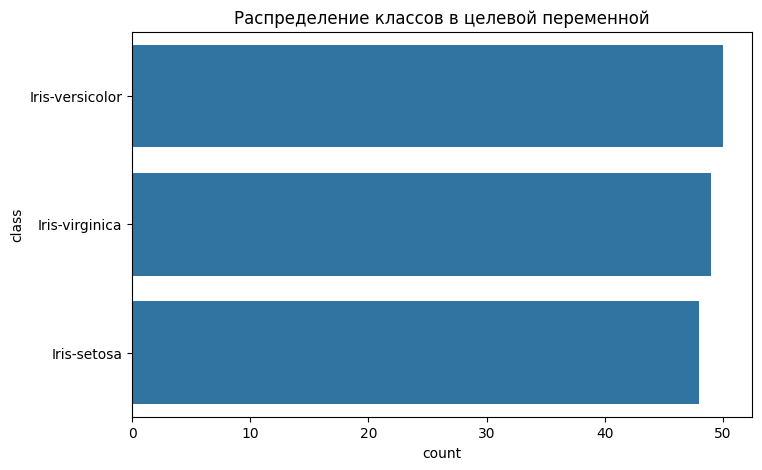

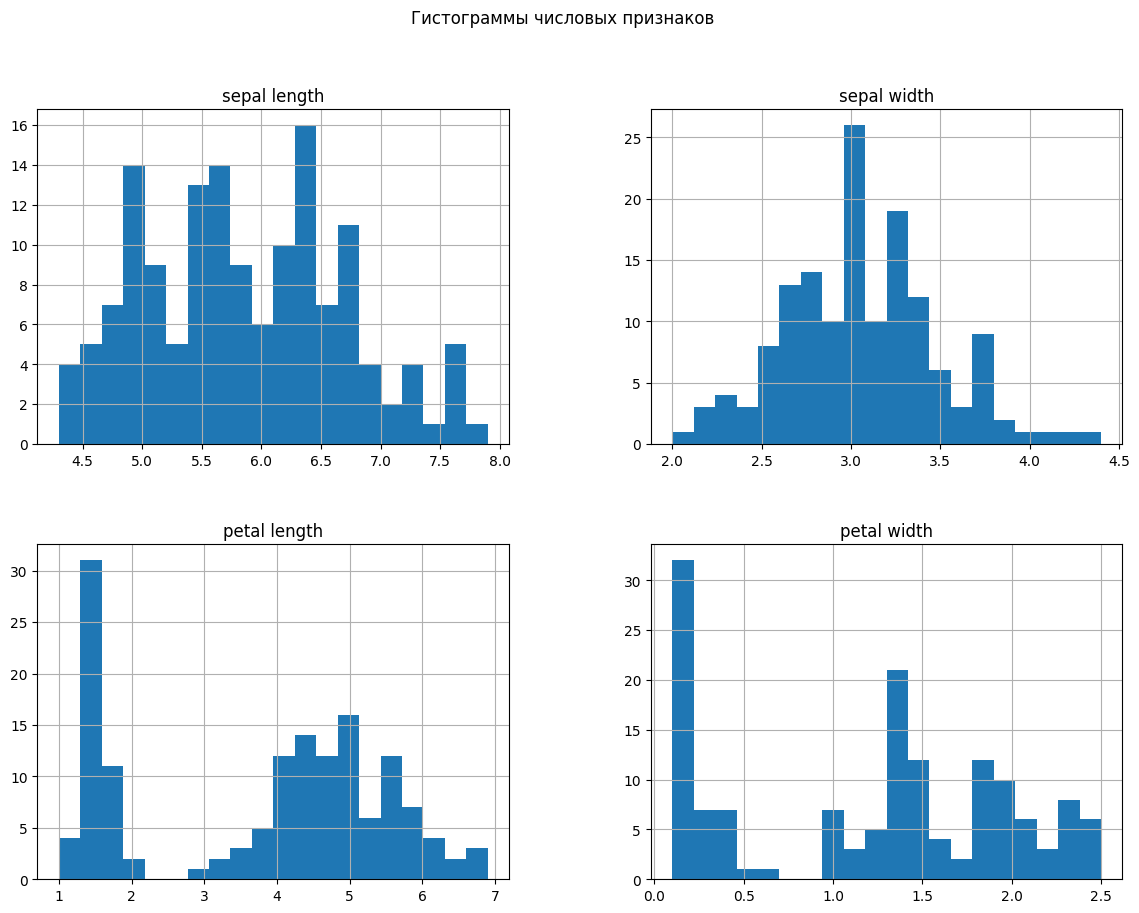

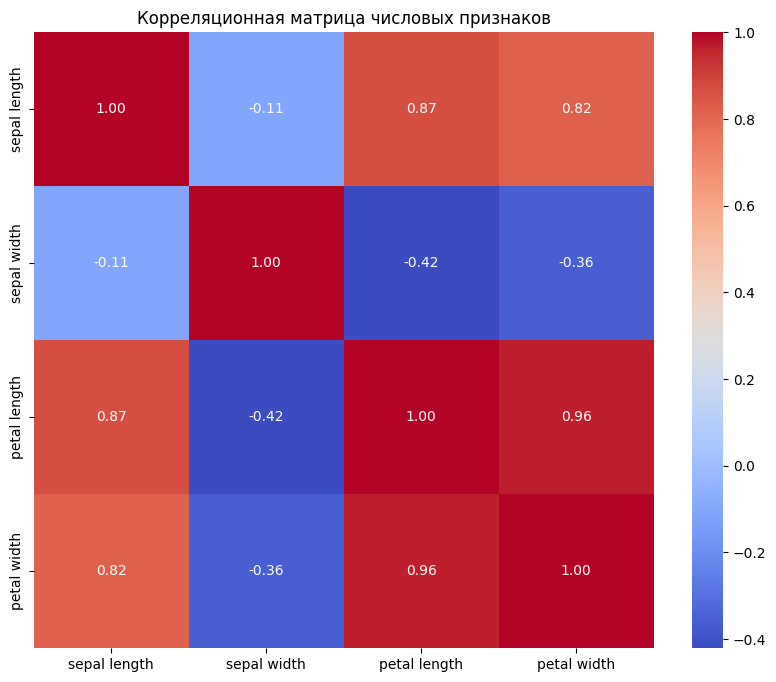

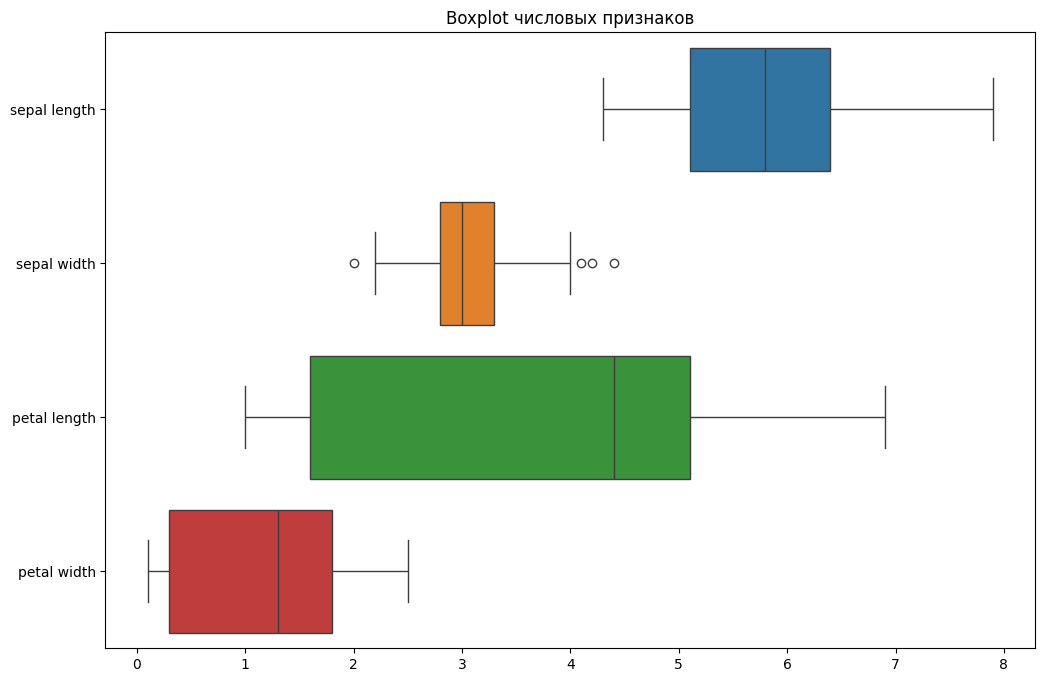

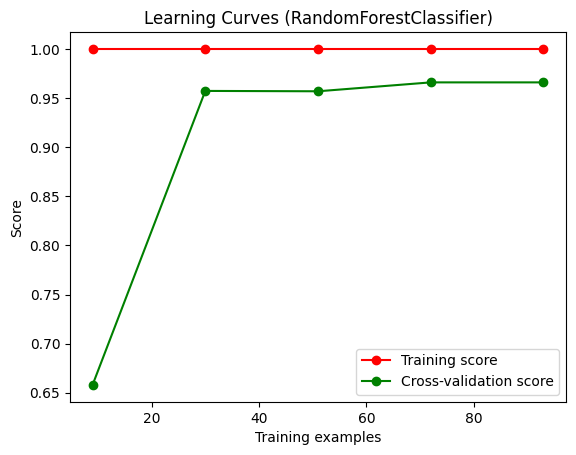

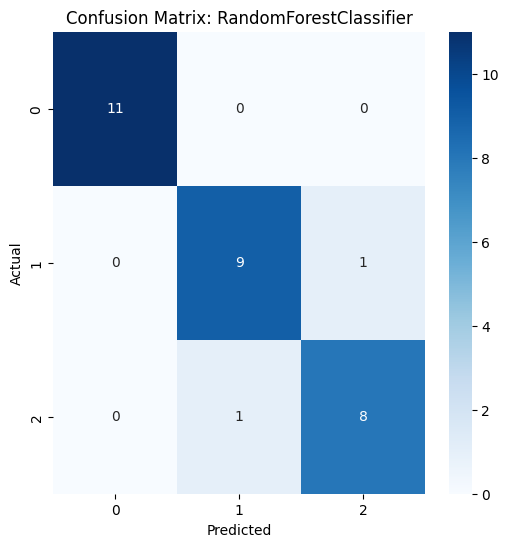

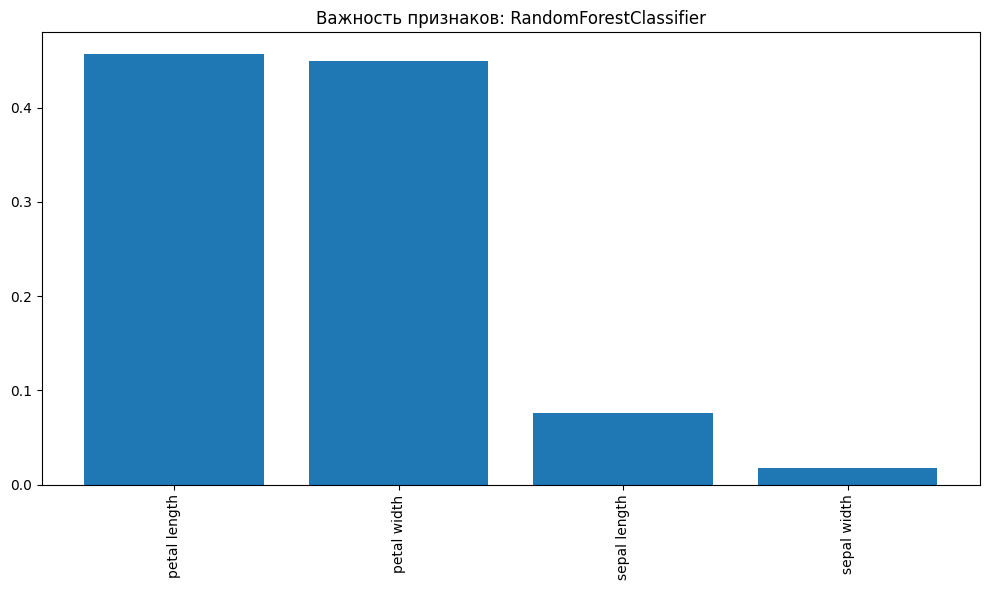

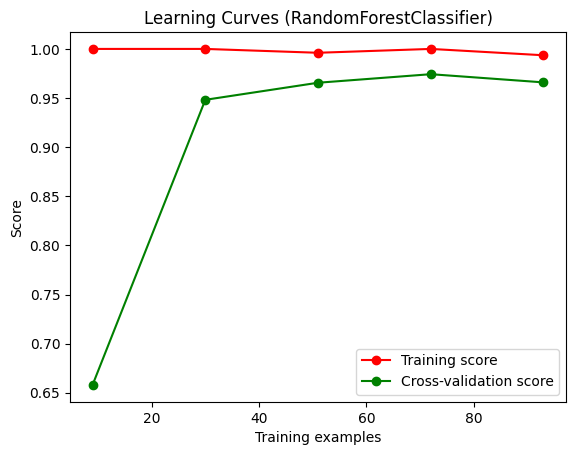

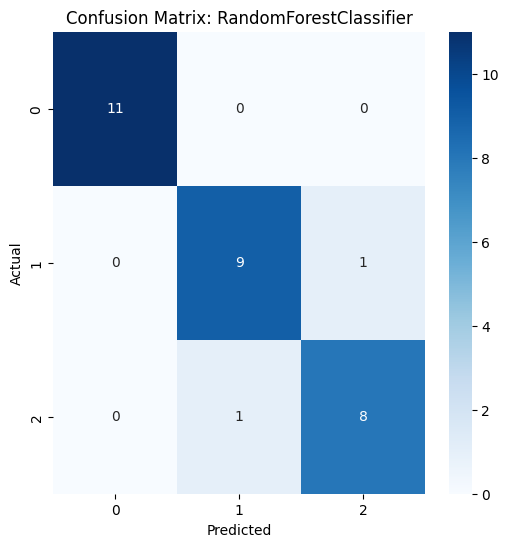

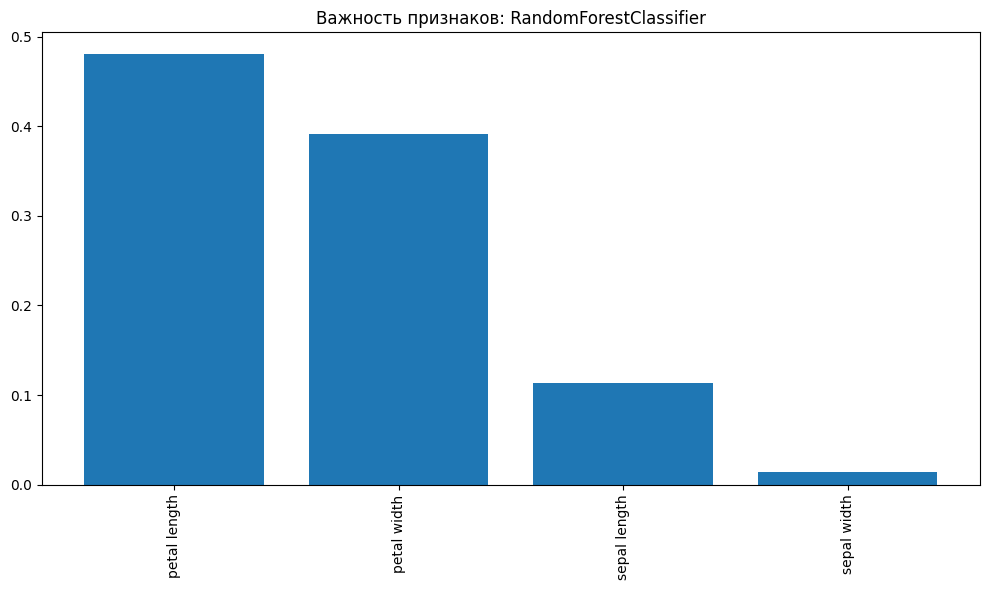

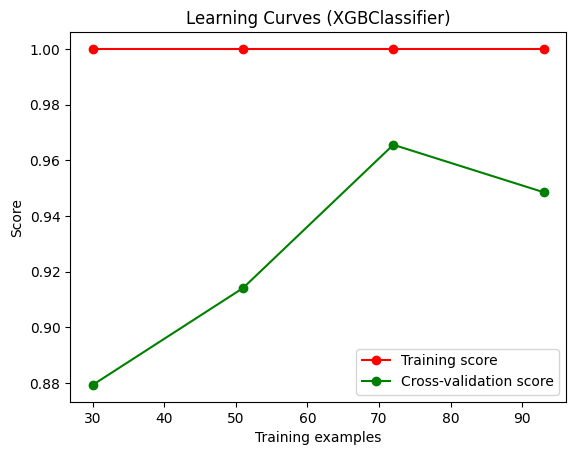

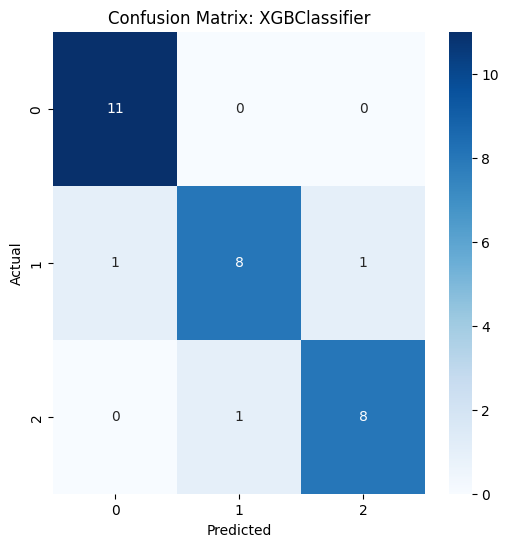

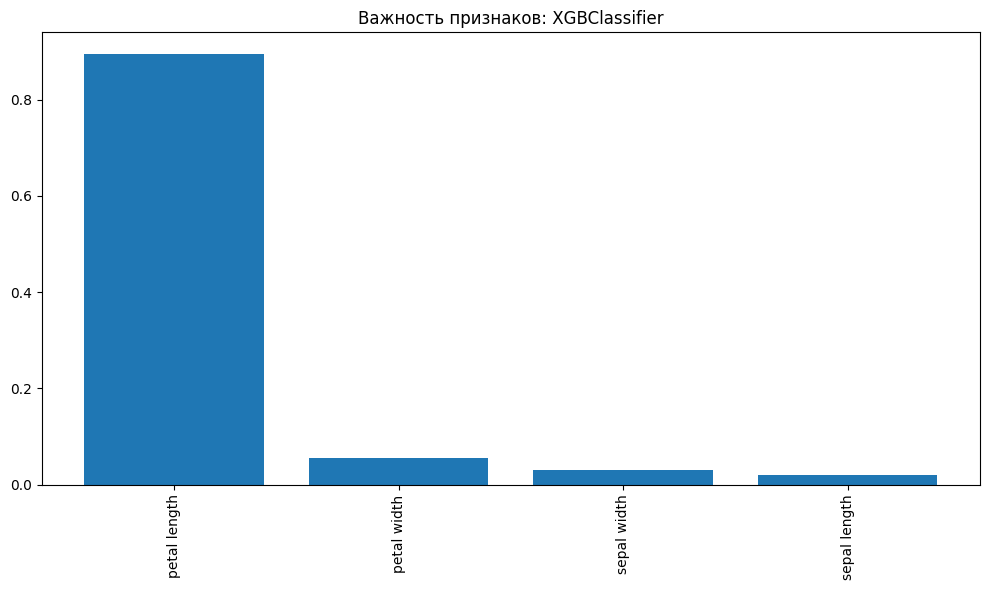

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 117, number of used features: 4
[LightGBM] [Info] Start training from score -1.151256
[LightGBM] [Info] Start training from score -1.073294
[LightGBM] [Info] Start training from score -1.073294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

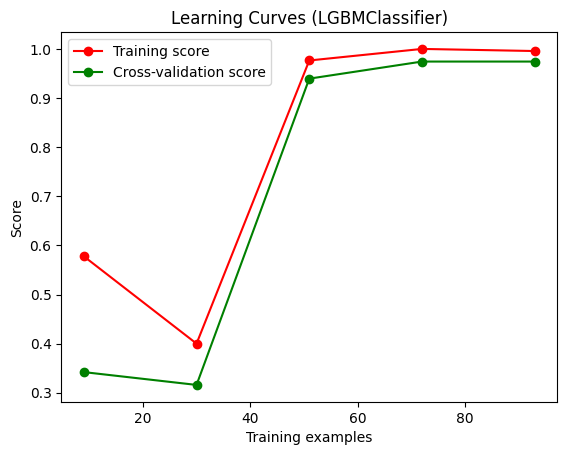

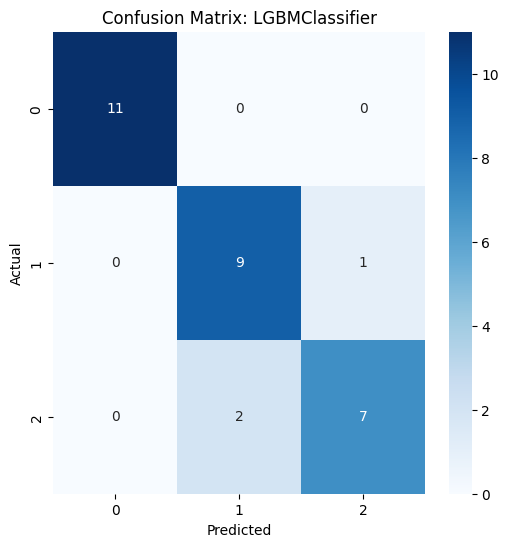

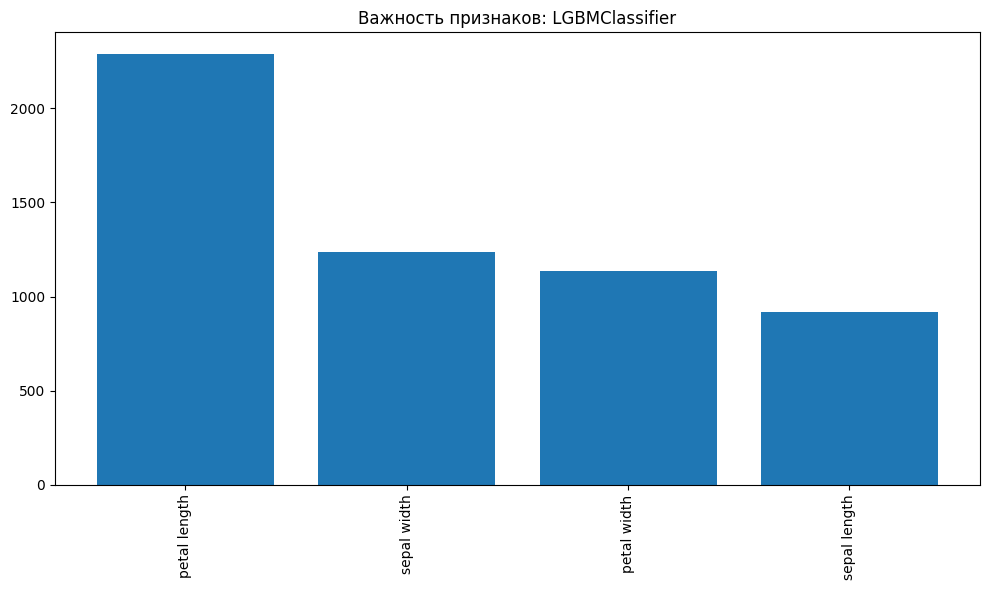

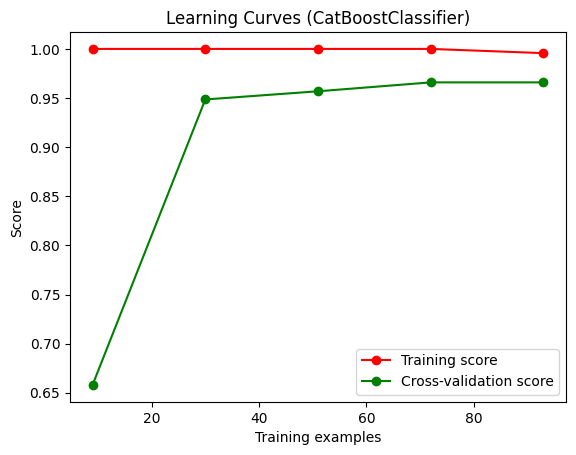

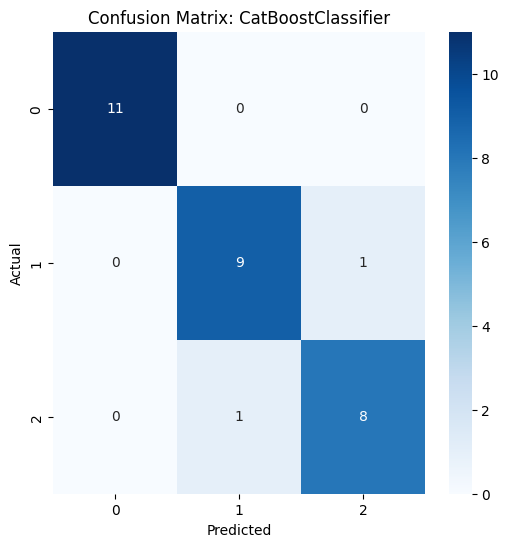

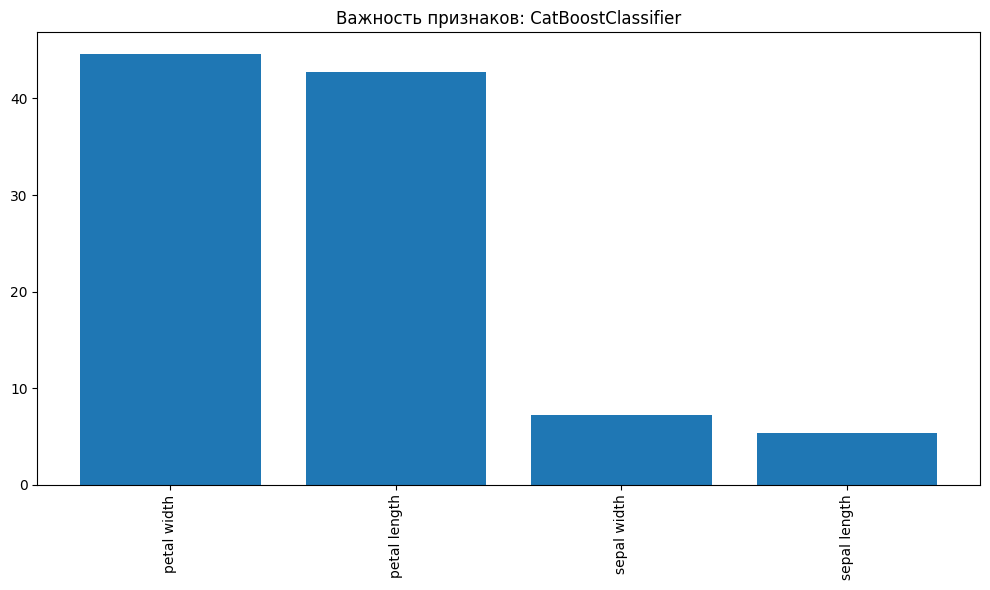

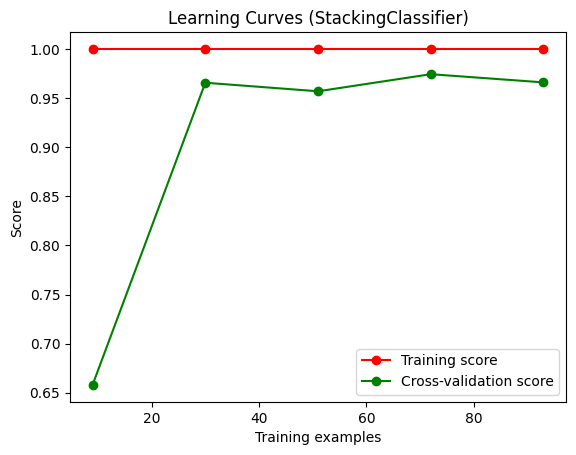

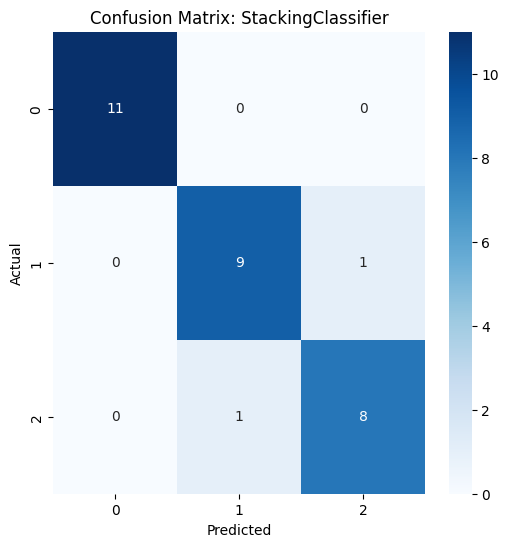

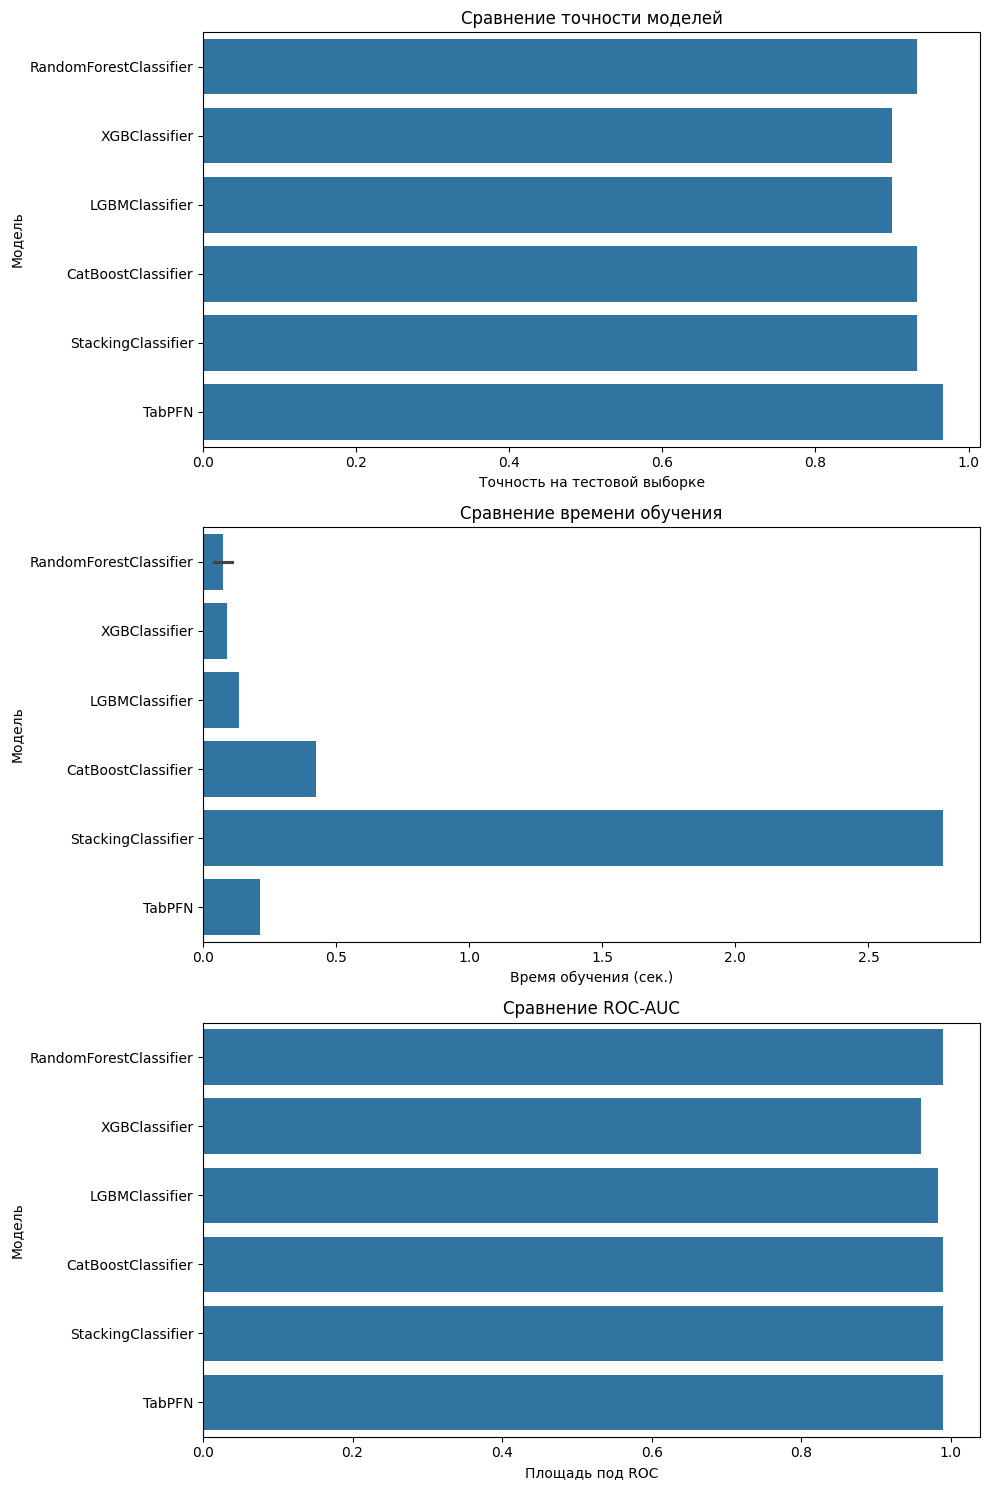

,Модель,Время обучения (сек.),Точность на тестовой выборке,Площадь под ROC
0,RandomForestClassifier,0.109740,0.933333,0.989709
1,RandomForestClassifier,0.042856,0.933333,0.989709
2,XGBClassifier,0.088716,0.900000,0.959853
3,LGBMClassifier,0.133994,0.900000,0.982848
4,CatBoostClassifier,0.424288,0.933333,0.989709
5,StackingClassifier,2.779988,0.933333,0.989709
6,TabPFN,0.213659,0.966667,0.989709


In [ ]:
dataset = 'iris'
try:
    results[dataset] = compare_models_classifier(dataset,models,params,ident)
    display(results[dataset])
except Exception as e:
    print(f'Возникла ошибка: {e}')

### Ionosphere

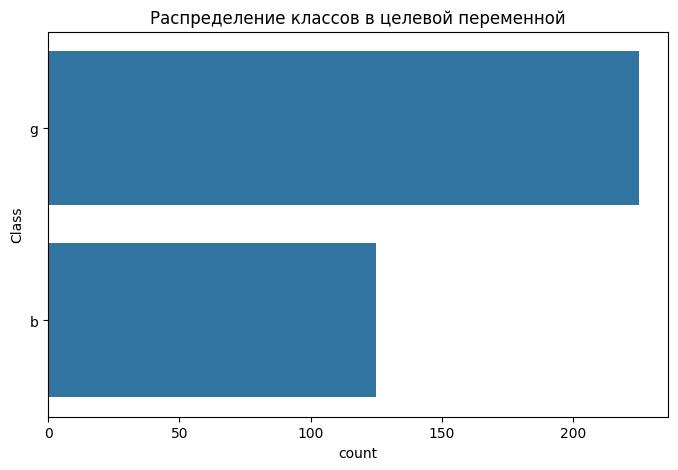

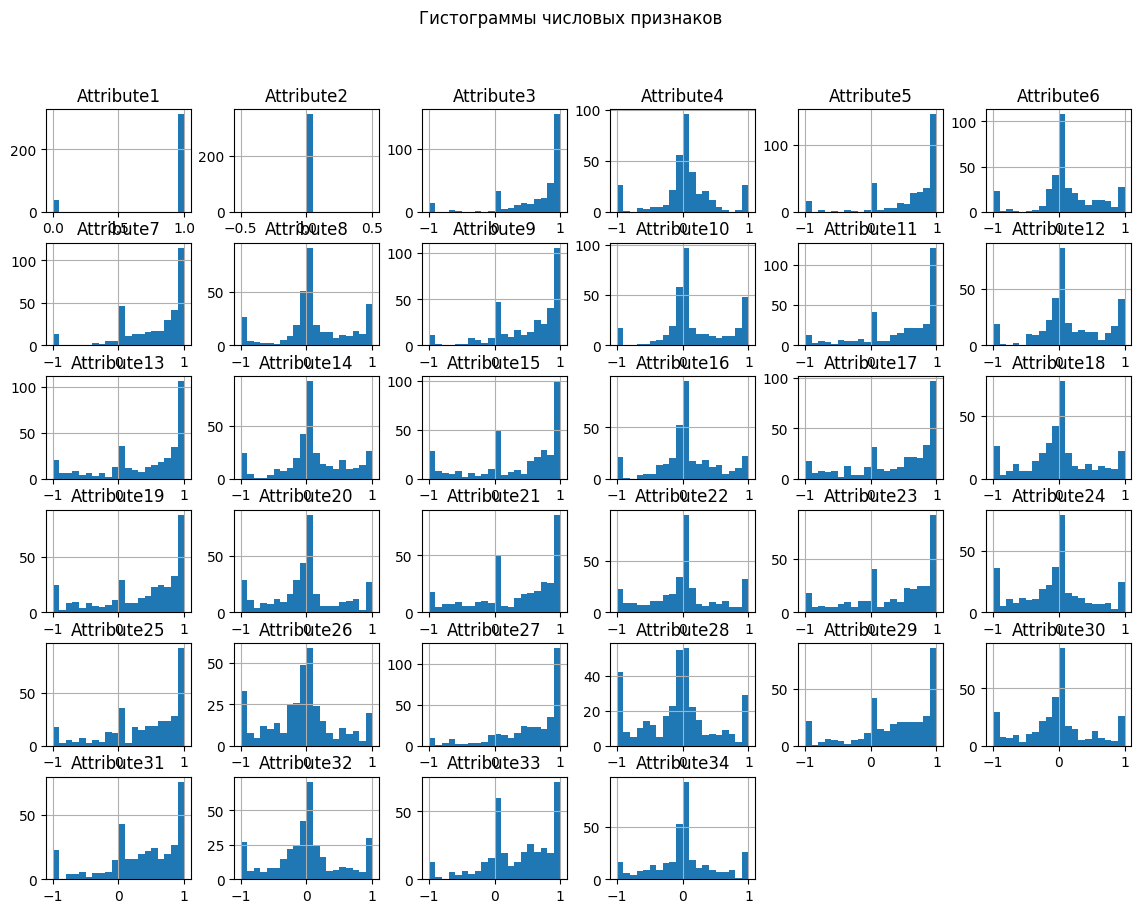

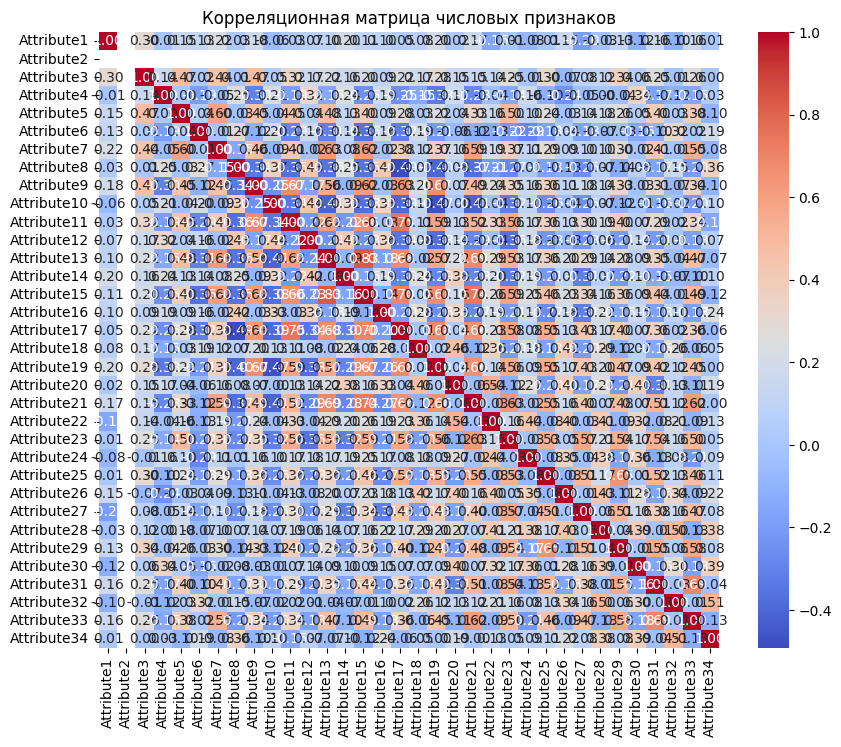

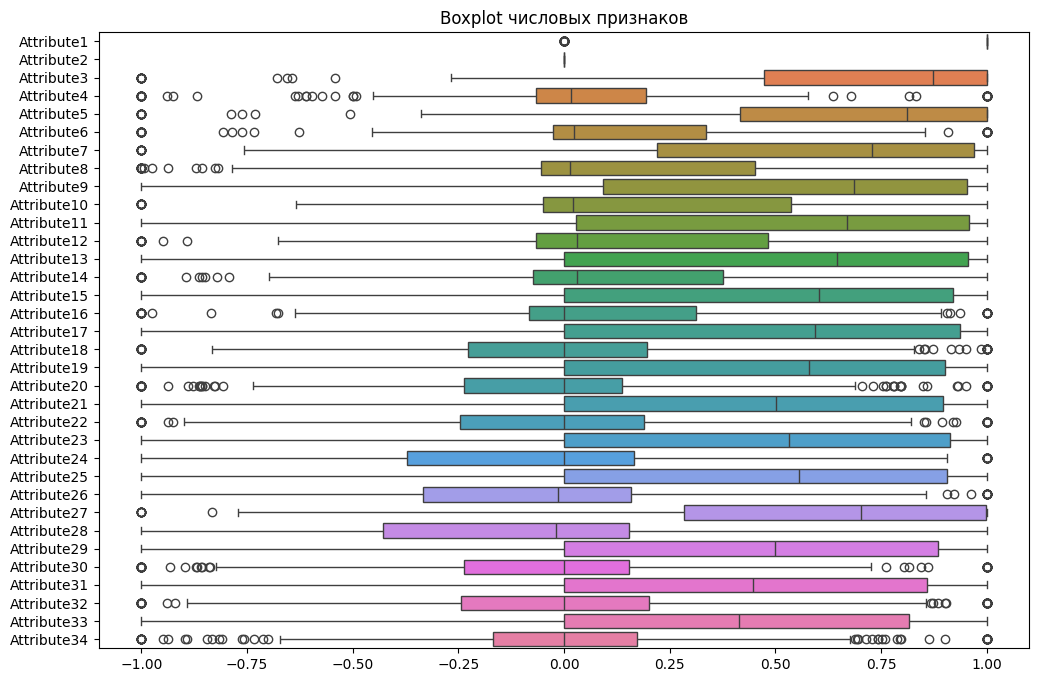

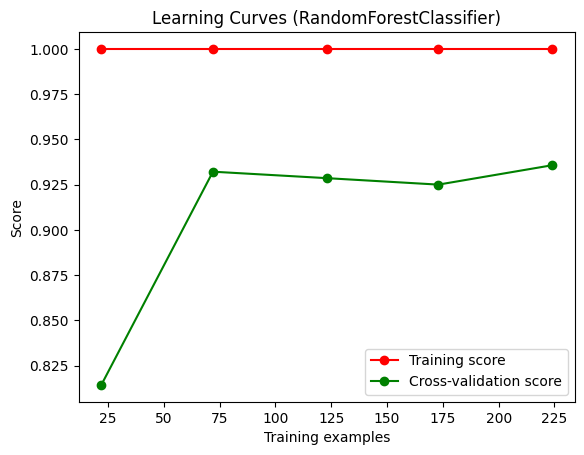

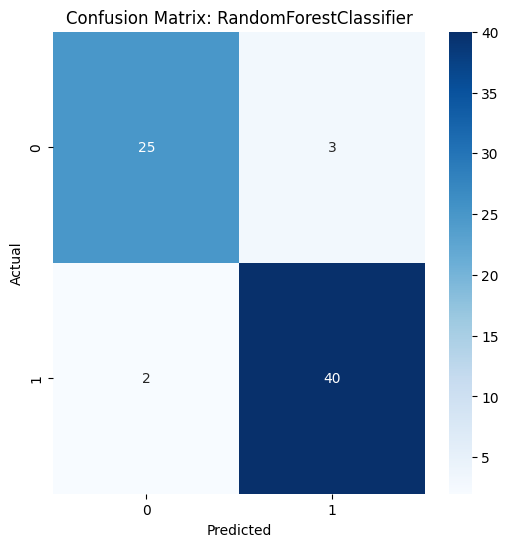

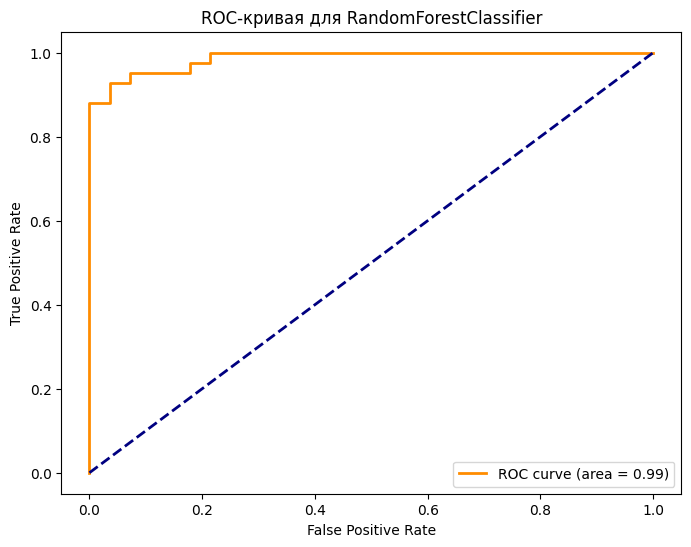

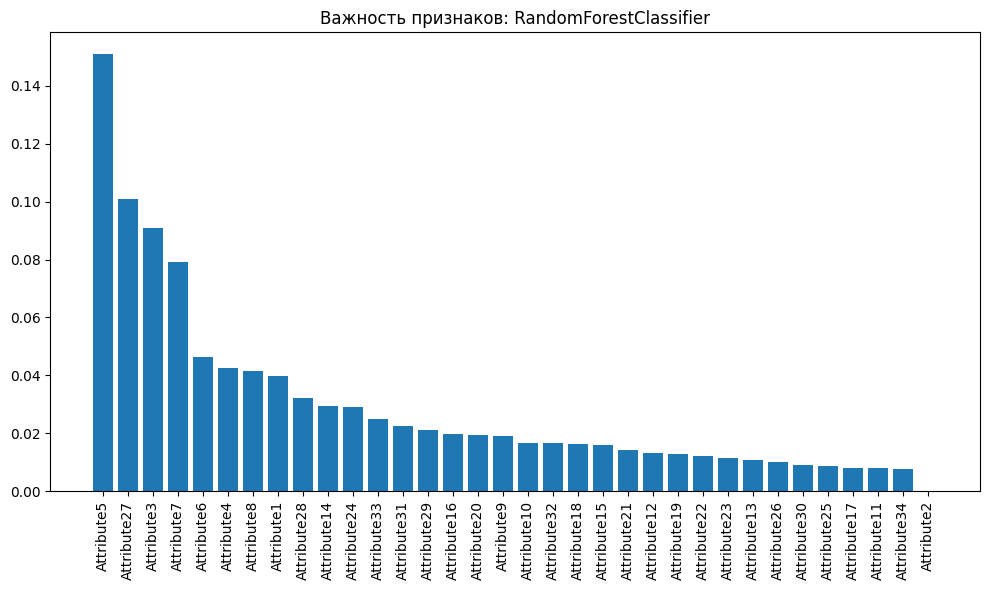

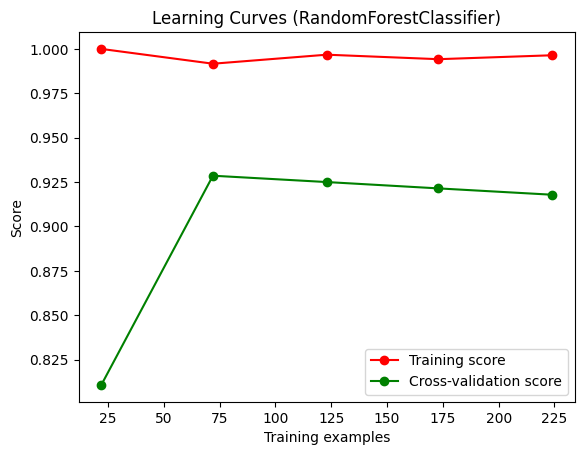

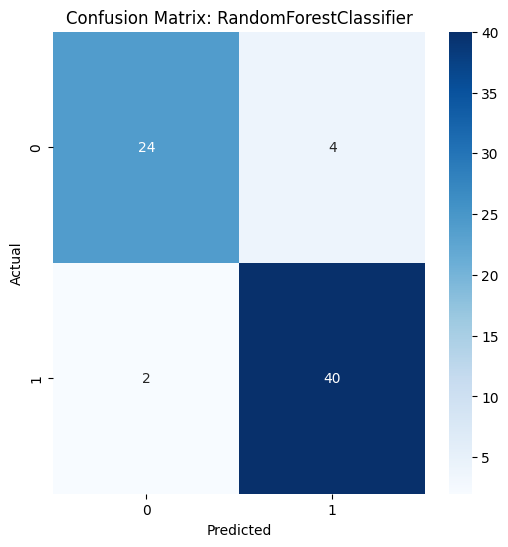

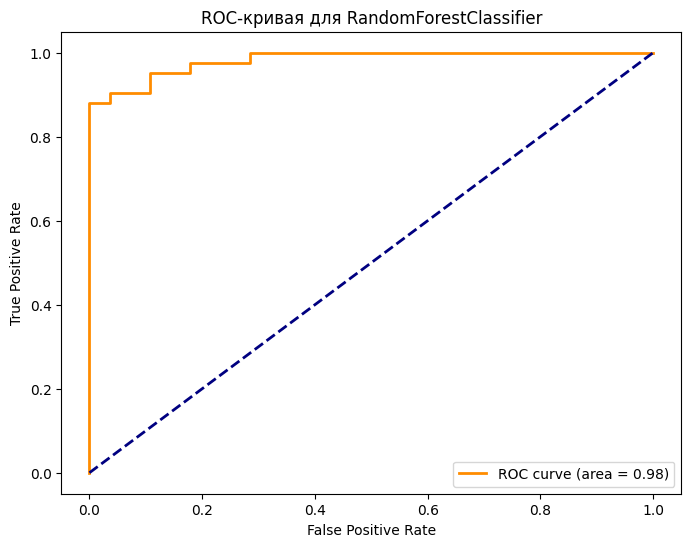

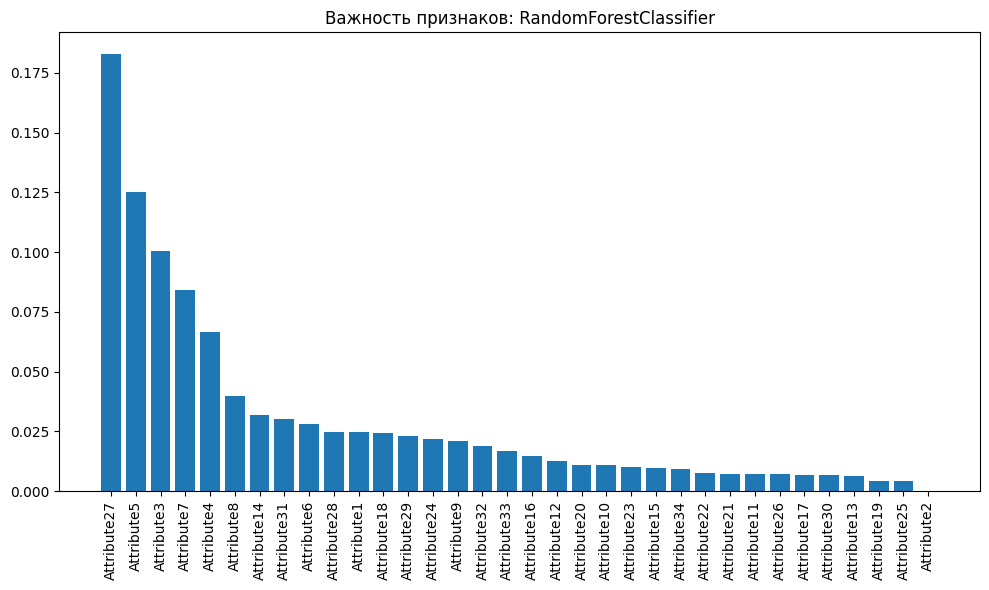

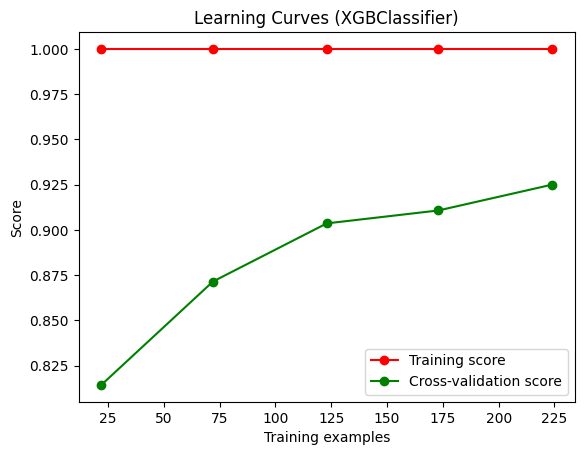

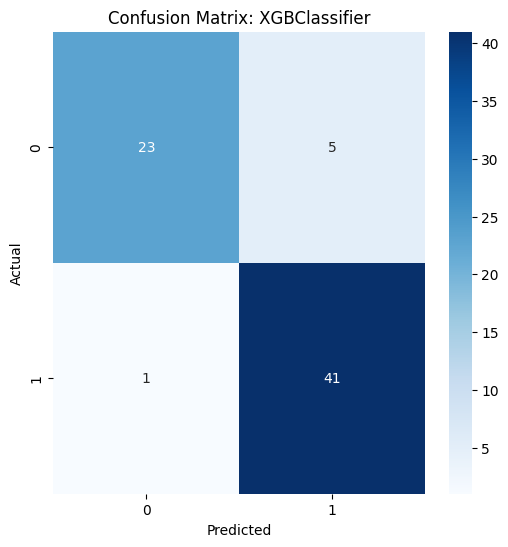

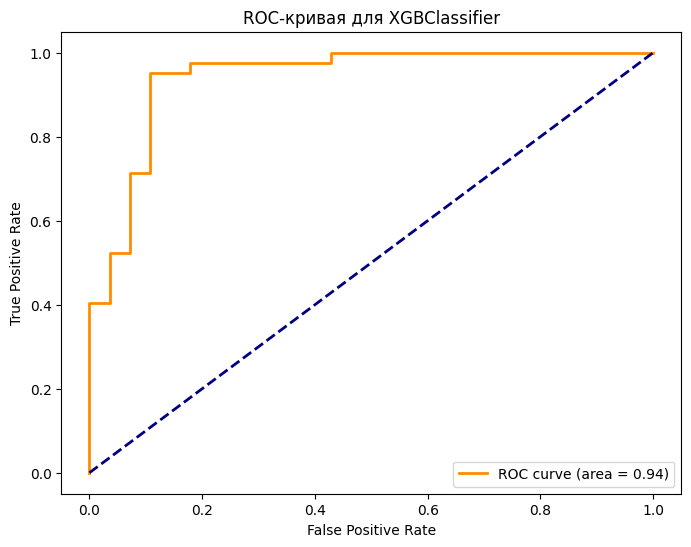

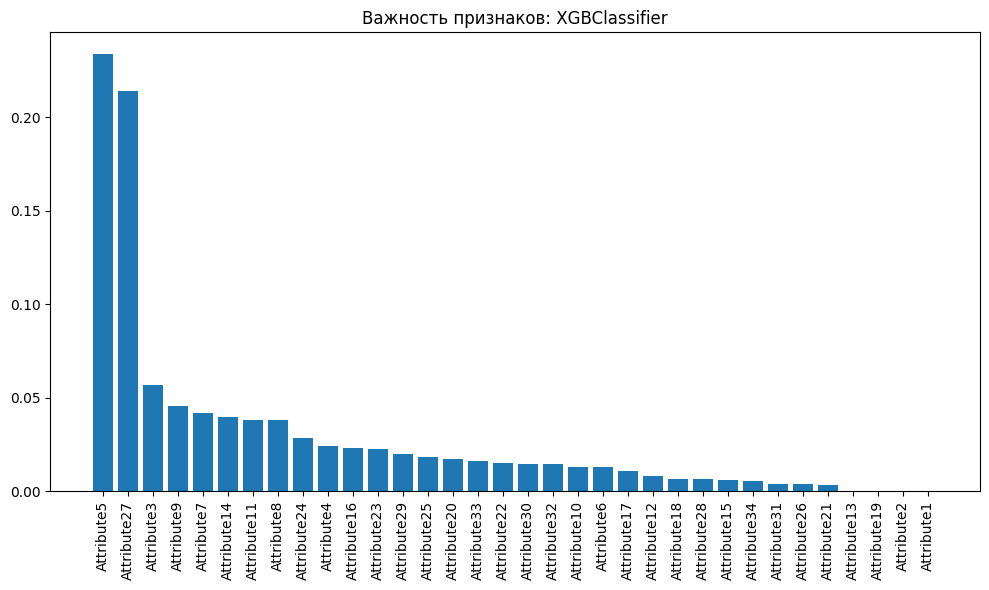

[LightGBM] [Info] Number of positive: 183, number of negative: 97
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2234
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.653571 -> initscore=0.634775
[LightGBM] [Info] Start training from score 0.634775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

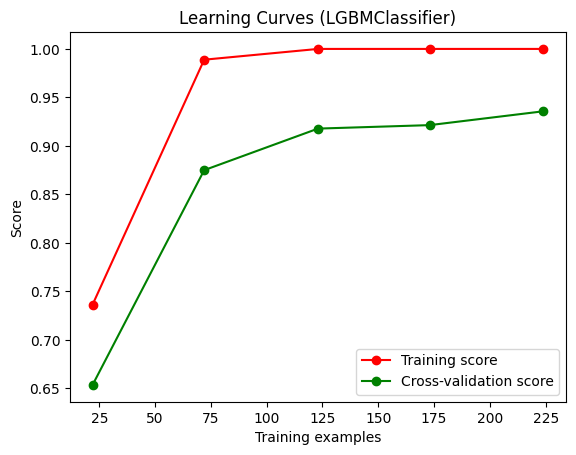

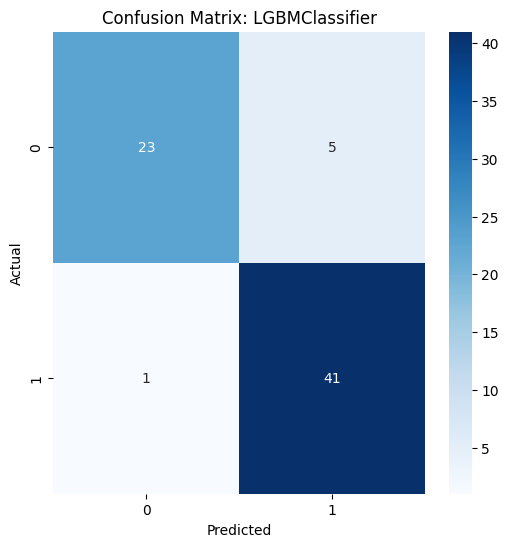

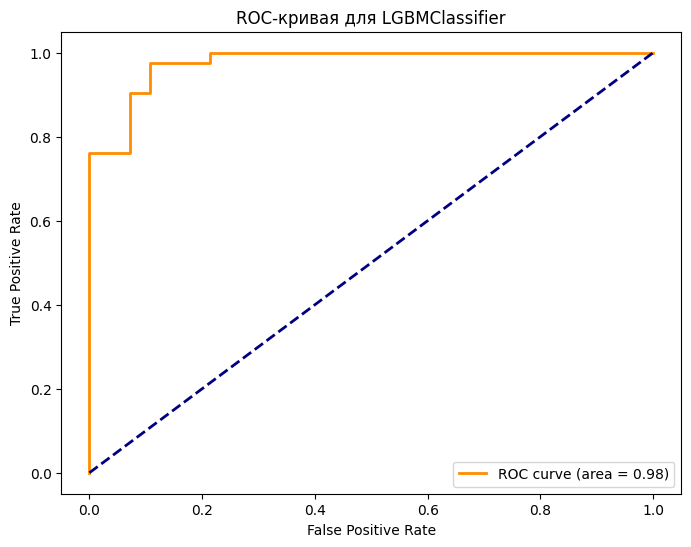

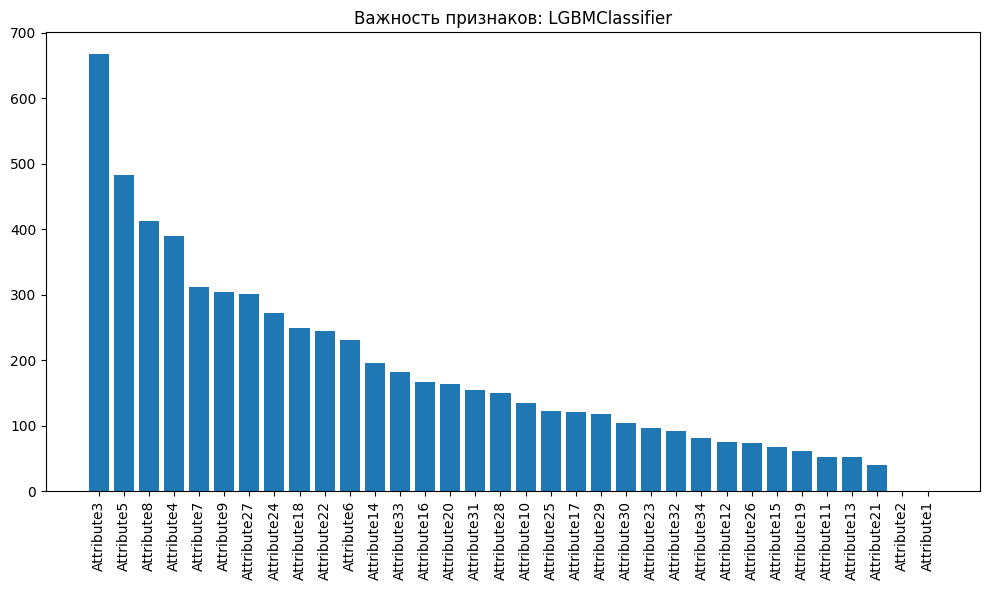

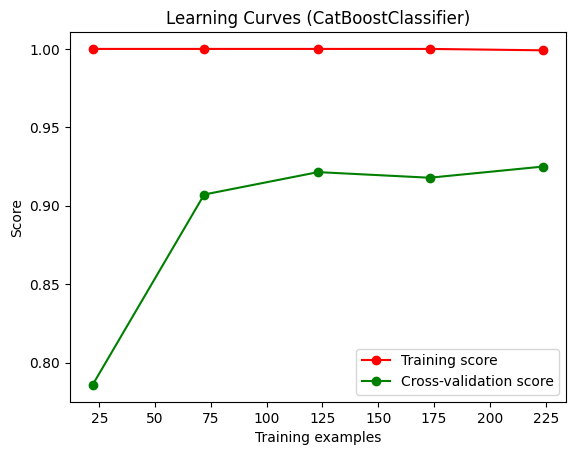

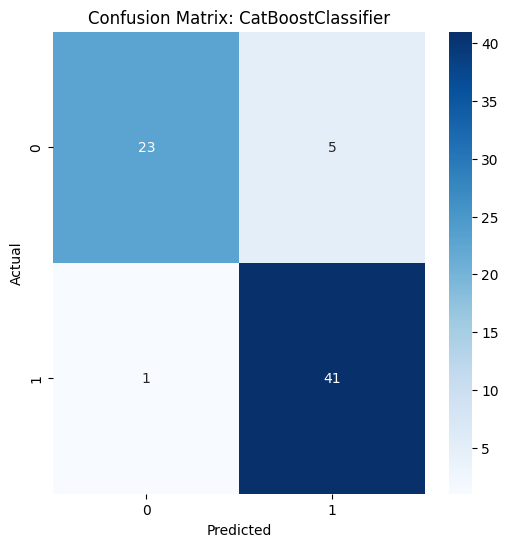

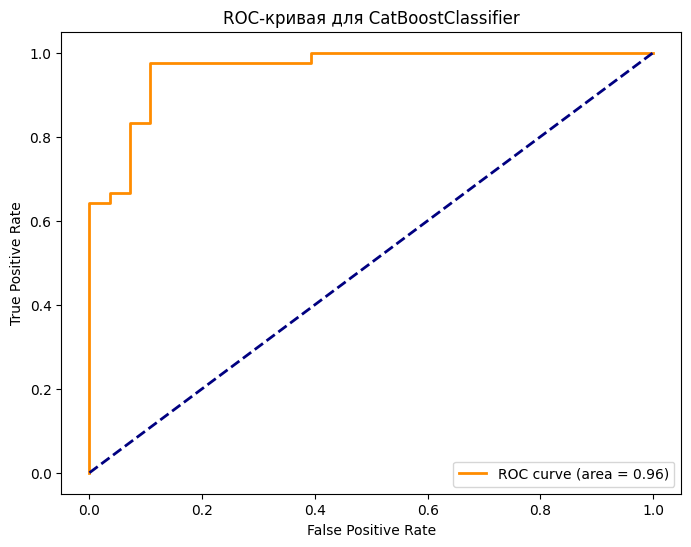

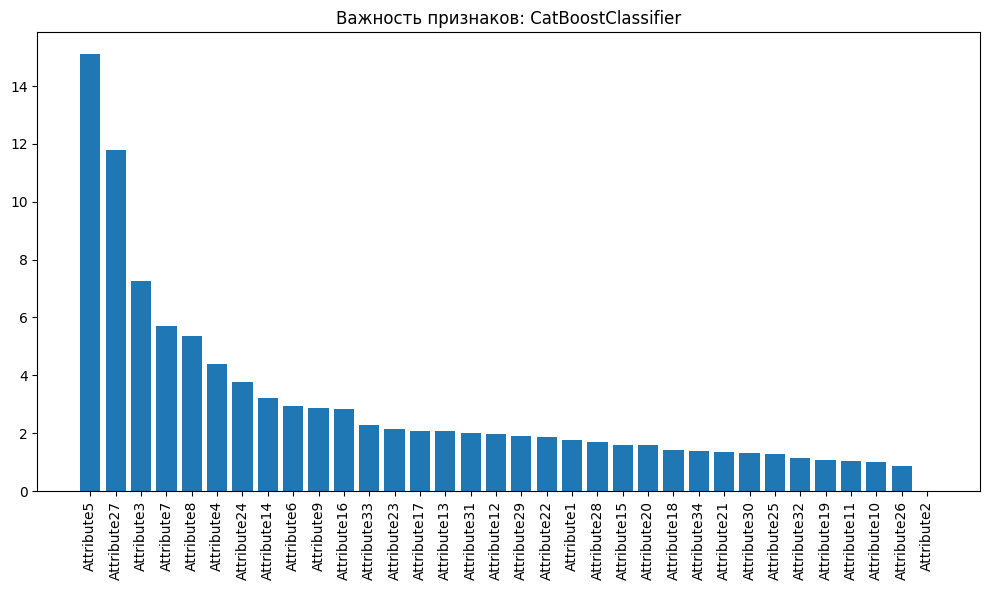

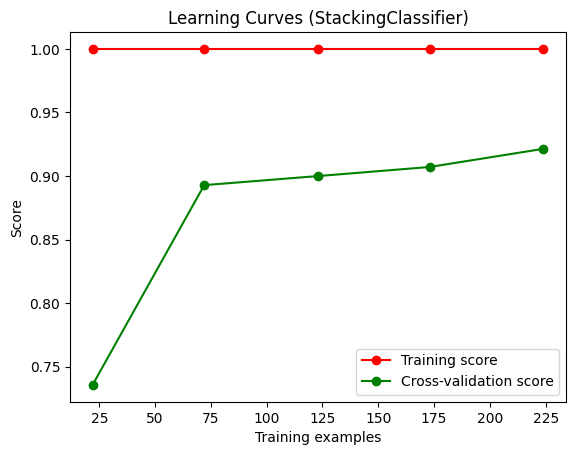

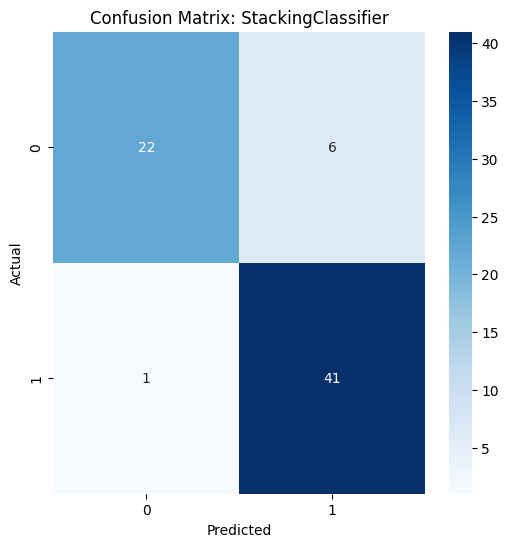

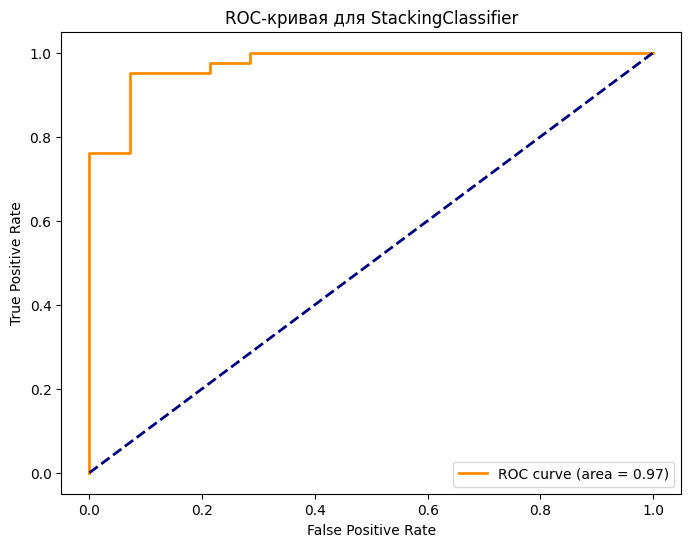

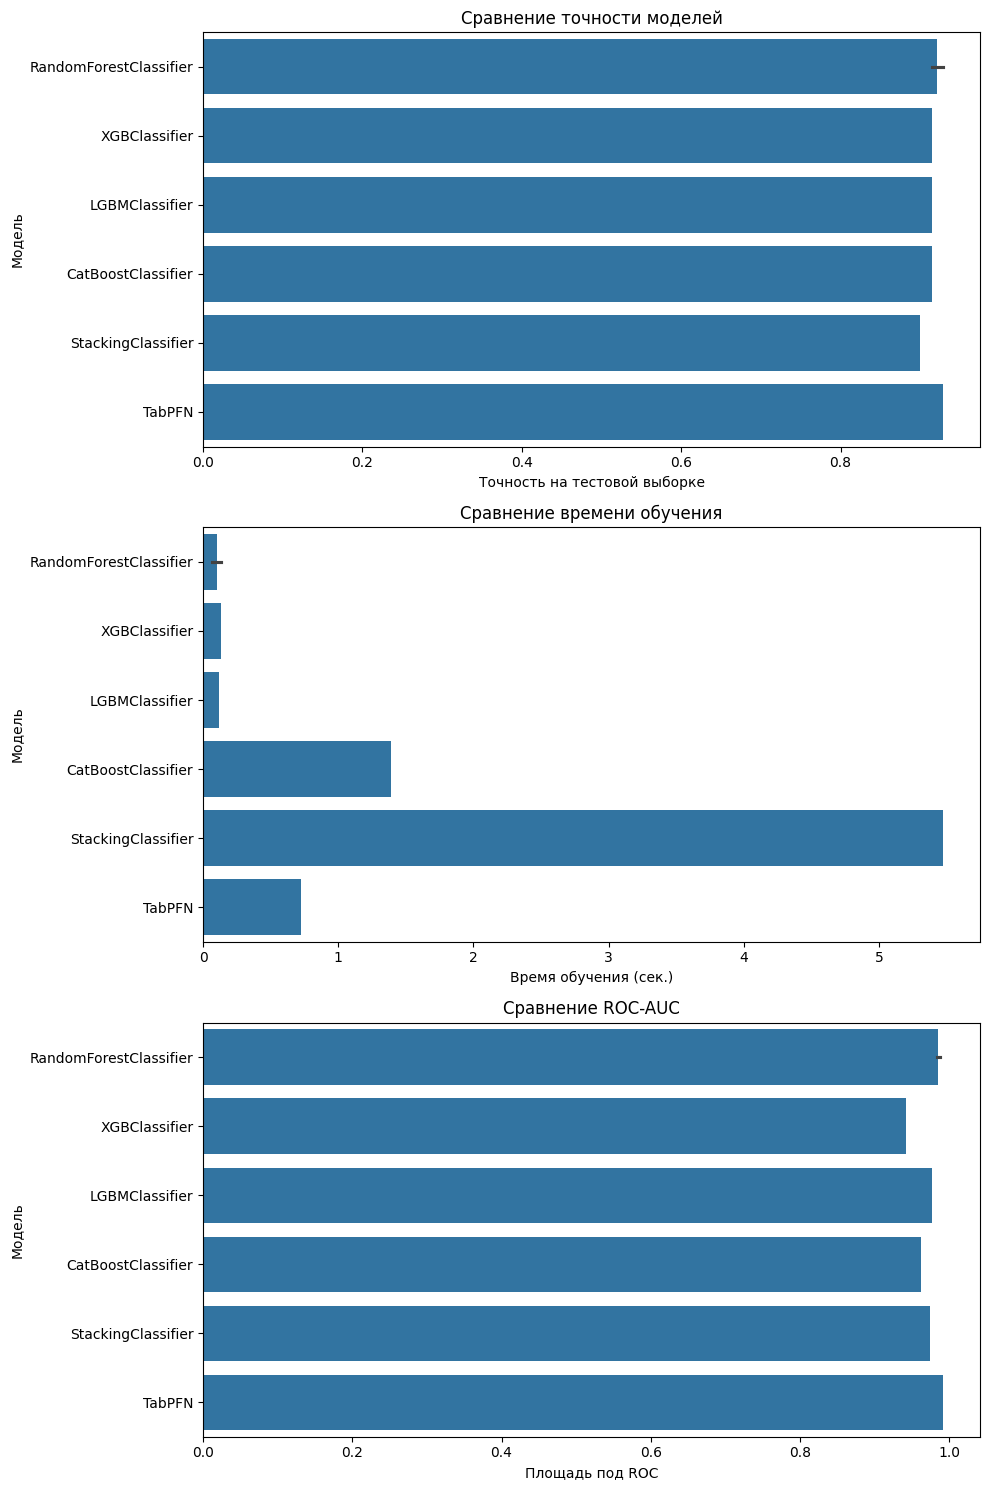

,Модель,Время обучения (сек.),Точность на тестовой выборке,Площадь под ROC
0,RandomForestClassifier,0.135185,0.928571,0.987245
1,RandomForestClassifier,0.068338,0.914286,0.982993
2,XGBClassifier,0.132253,0.914286,0.942177
3,LGBMClassifier,0.116482,0.914286,0.977041
4,CatBoostClassifier,1.390783,0.914286,0.962585
5,StackingClassifier,5.473171,0.900000,0.974490
6,TabPFN,0.727200,0.928571,0.991497


In [108]:
dataset = 'Ionosphere'
try:
    results[dataset] = compare_models_classifier(dataset,models,params,ident)
    display(results[dataset])
except Exception as e:
    print(f'Возникла ошибка: {e}')

### ttt

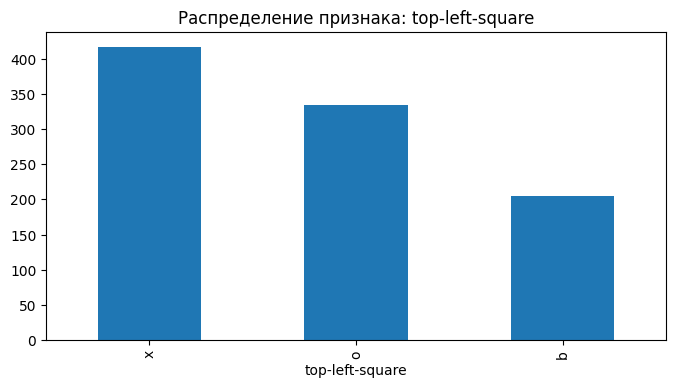

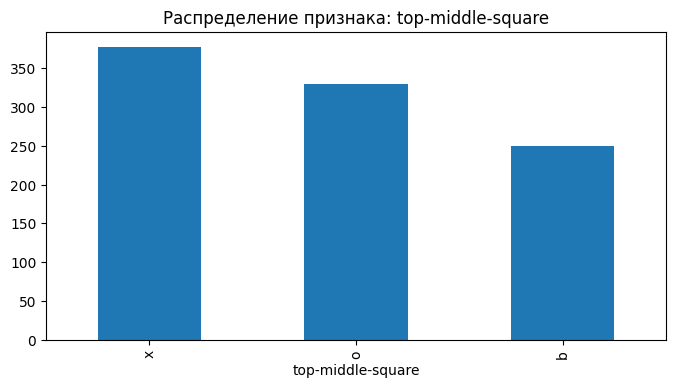

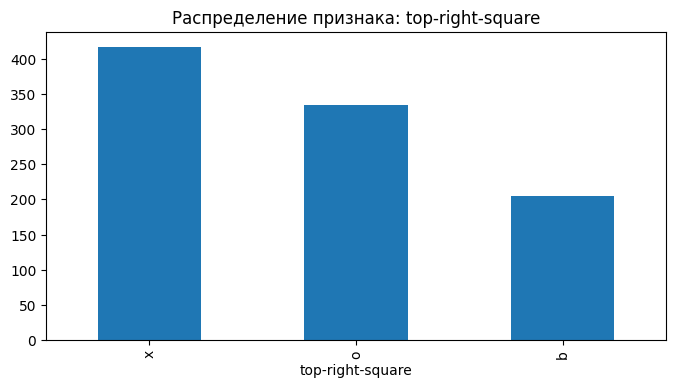

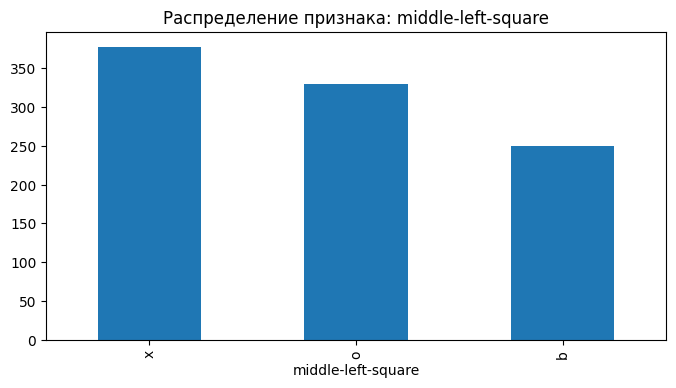

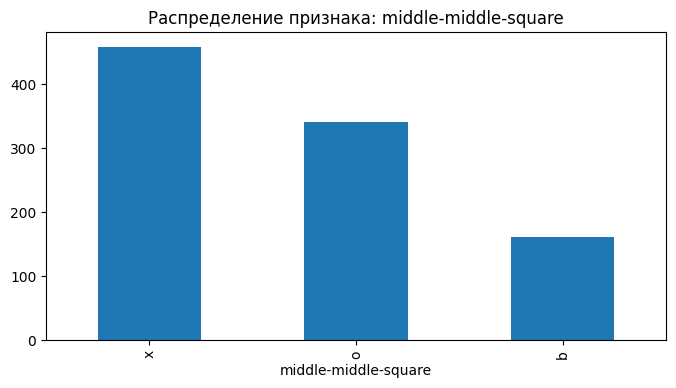

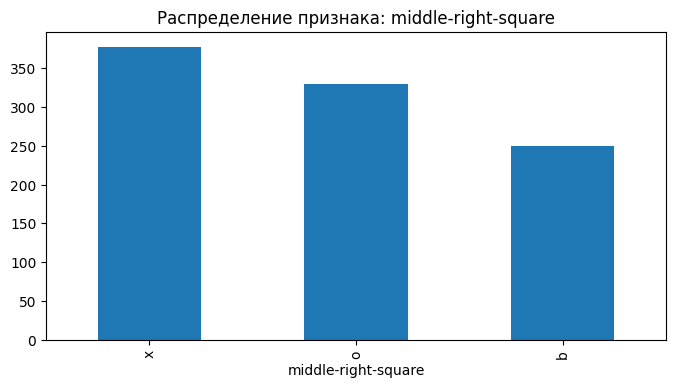

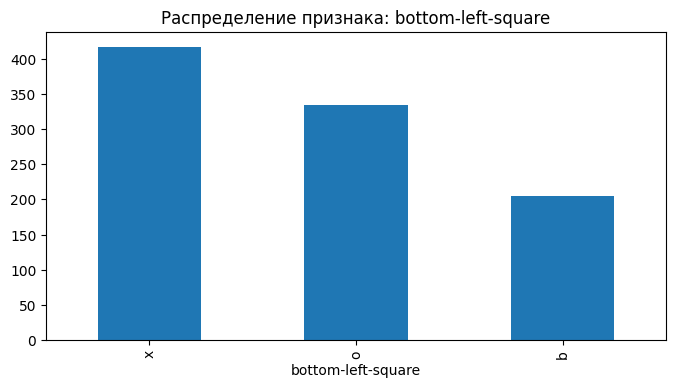

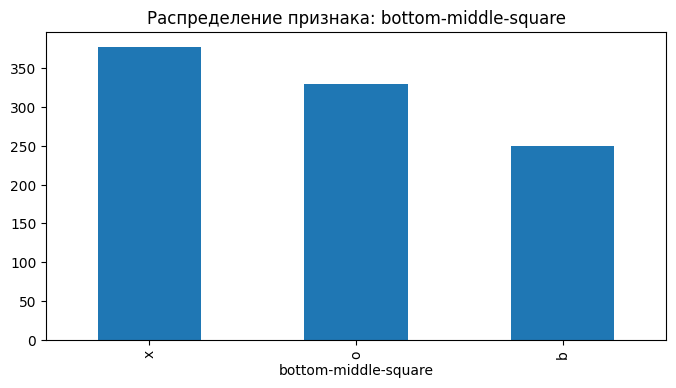

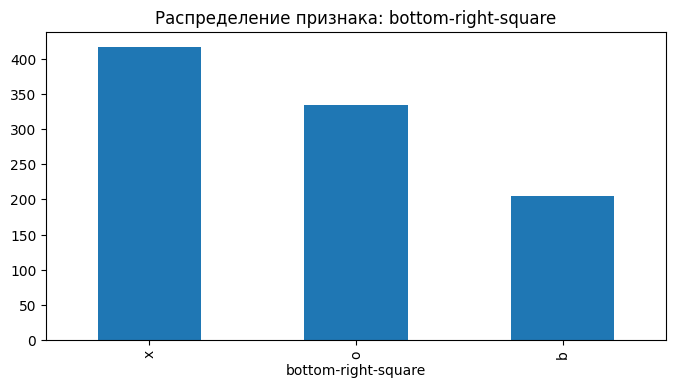

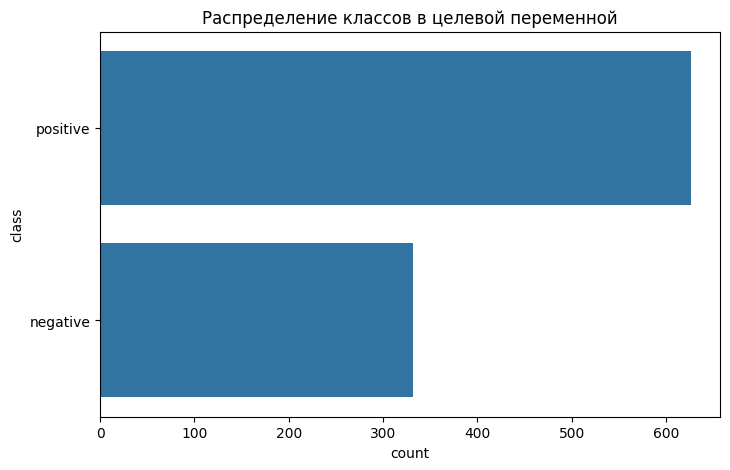

Возникла ошибка: hist method requires numerical or datetime columns, nothing to plot.


In [109]:
dataset = 'ttt'
try:
    results[dataset] = compare_models_classifier(dataset,models,params,ident)
    display(results[dataset])
except Exception as e:
    print(f'Возникла ошибка: {e}')

для 6 датасетов потребовалось 16 минут

Результаты работы на 6 датасетах:

In [164]:
results

{'iris':                    Модель  Время обучения (сек.)  \
 0  RandomForestClassifier               0.091625   
 1  RandomForestClassifier               0.043970   
 2           XGBClassifier               0.066886   
 3          LGBMClassifier               0.156515   
 4      CatBoostClassifier               0.374439   
 5      StackingClassifier               6.908332   
 6                  TabPFN               0.201437   
 
    Точность на тестовой выборке  Площадь под ROC  
 0                      0.933333         0.989709  
 1                      0.933333         0.989709  
 2                      0.900000         0.959853  
 3                      0.900000         0.982848  
 4                      0.933333         0.989709  
 5                      0.933333         0.989709  
 6                      0.966667         0.989709  ,
 'Ionosphere':                    Модель  Время обучения (сек.)  \
 0  RandomForestClassifier               0.133616   
 1  RandomForestClassifier   

В большинстве случаев возможного использования алгоритм TabFPN показывает себя лучше многих ансамблевых моделей как по времени обучения и предсказания, так и по метрикам эффективности